# Baseline Model - Versione Integrata

**Approccio unificato che combina:**
- ✅ **Tuo progetto**: Domain knowledge, validation strategy
- ✅ **Repository riferimento**: Quantile Loss (α=0.2), CatBoost + Optuna optimization

**Pipeline**: train_data.csv → CatBoost con Quantile Loss → Modello ottimizzato

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Advanced ML libraries
import optuna
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import pickle

print("🚀 Baseline Model - Versione Integrata")
print("   Combinando il meglio del tuo progetto + repository riferimento")

# Configuration (dal repository di riferimento)
RANDOM_STATE = 42
N_TRIALS = 50  # Optuna trials (ridotto per efficienza)
N_FOLDS = 5    # CV folds
ALPHA = 0.2    # Quantile loss parameter (chiave del repository)

np.random.seed(RANDOM_STATE)
print("✅ Configurazione ottimizzata caricata")

🚀 Baseline Model - Versione Integrata
   Combinando il meglio del tuo progetto + repository riferimento
✅ Configurazione ottimizzata caricata


## 1. Load Data & Prepare Features

In [2]:
# Carica i dataset con 52 feature avanzate
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

print(f"📊 Dataset con feature avanzate:")
print(f"   Training set: {train.shape}")
print(f"   Test set: {test.shape}")

# Converti date per analisi temporale
train['date_arrival'] = pd.to_datetime(train['date_arrival'])
test['date_arrival'] = pd.to_datetime(test['date_arrival'])

# Identifica features e target
target_col = 'net_weight'
exclude_cols = ['date_arrival', 'rm_id', 'supplier_id', 'product_id', 'receival_status', target_col]
feature_cols = [col for col in train.columns if col not in exclude_cols]

print(f"\n✅ Feature per ML: {len(feature_cols)} features")
print(f"   Target: {target_col}")
print(f"   Range temporale training: {train['date_arrival'].min()} → {train['date_arrival'].max()}")
print(f"   Range temporale test: {test['date_arrival'].min()} → {test['date_arrival'].max()}")

# Prepara X, y
X_train = train[feature_cols].copy()
y_train = train[target_col].copy()
X_test = test[feature_cols].copy()
y_test = test[target_col].copy()

print(f"\n📊 Target statistics:")
print(f"   Training - Mean: {y_train.mean():.0f}, Std: {y_train.std():.0f}")
print(f"   Test - Mean: {y_test.mean():.0f}, Std: {y_test.std():.0f}")

📊 Dataset con feature avanzate:
   Training set: (33525, 60)
   Test set: (8382, 60)

✅ Feature per ML: 54 features
   Target: net_weight
   Range temporale training: 2004-06-15 00:00:00 → 2022-03-01 00:00:00
   Range temporale test: 2022-03-01 00:00:00 → 2024-12-19 00:00:00

📊 Target statistics:
   Training - Mean: 40177, Std: 51811
   Test - Mean: 28931, Std: 30268


## 2. Quantile Loss Implementation (Repository Approach)

In [3]:
# QUANTILE LOSS - Chiave del repository di riferimento per gestire target imbalanced
# α=0.2 significa che penalizziamo di più le sottostime (importante per supply chain)

def quantile_loss(y_true, y_pred, alpha=0.2):
    """
    Quantile Loss per regressione.
    Alpha=0.2: Penalizza più le sottostime che le sovrastime
    """
    errors = y_true - y_pred
    loss = np.where(errors >= 0, 
                   alpha * errors,           # Sottostima (errore positivo)
                   (alpha - 1) * errors)     # Sovrastima (errore negativo)
    return np.mean(loss)

def quantile_score(y_true, y_pred, alpha=0.2):
    """
    Score version (lower = better)
    """
    return -quantile_loss(y_true, y_pred, alpha)

# Test della funzione
print("🔄 Test Quantile Loss function...")
y_true_test = np.array([100, 200, 300])
y_pred_test = np.array([90, 250, 280])  # sottostima, sovrastima, sottostima

ql_02 = quantile_loss(y_true_test, y_pred_test, alpha=0.2)
mae_test = mean_absolute_error(y_true_test, y_pred_test)

print(f"   MAE tradizionale: {mae_test:.2f}")
print(f"   Quantile Loss (α=0.2): {ql_02:.2f}")
print(f"   ✅ Quantile Loss preferisce modelli che evitano sottostime")

🔄 Test Quantile Loss function...
   MAE tradizionale: 26.67
   Quantile Loss (α=0.2): 15.33
   ✅ Quantile Loss preferisce modelli che evitano sottostime


## 3. Cross-Validation Setup

In [4]:
# CROSS-VALIDATION con Quantile Loss
# Importante: per time series, usiamo KFold normale ma verifichiamo che sia appropriato

def cv_score_quantile(model, X, y, alpha=0.2, n_folds=5, random_state=42):
    """
    Cross-validation con Quantile Loss
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        # Split
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train
        model.fit(X_tr, y_tr)
        
        # Predict
        y_pred = model.predict(X_val)
        
        # Score
        score = quantile_loss(y_val, y_pred, alpha)
        scores.append(score)
        
        print(f"   Fold {fold+1}: Quantile Loss = {score:.2f}")
    
    return np.array(scores)

print("✅ Cross-validation setup per Quantile Loss pronto")
print(f"   Folds: {N_FOLDS}")
print(f"   Alpha: {ALPHA}")
print(f"   Seed: {RANDOM_STATE}")

✅ Cross-validation setup per Quantile Loss pronto
   Folds: 5
   Alpha: 0.2
   Seed: 42


## 4. CatBoost Optimization con Optuna

In [5]:
# OPTUNA OPTIMIZATION per CatBoost con Quantile Loss
# Repository approach: ottimizzazione automatica hyperparameters

def objective_catboost(trial):
    """
    Objective function per Optuna - CatBoost optimization
    """
    # Hyperparameters space (basato su repository riferimento)
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_seed': RANDOM_STATE,
        'verbose': False,
        'loss_function': 'MAE'  # CatBoost non ha Quantile Loss built-in, usiamo MAE
    }
    
    # Model
    model = CatBoostRegressor(**params)
    
    # CV con Quantile Loss (custom metric)
    scores = cv_score_quantile(model, X_train, y_train, alpha=ALPHA, n_folds=N_FOLDS)
    
    # Return mean score (Optuna minimizza)
    return scores.mean()

print("🔄 Avvio Optuna optimization per CatBoost...")
print(f"   Trials: {N_TRIALS}")
print(f"   Timeout: nessuno (basato su trials)")

# Crea study e ottimizza
study_catboost = optuna.create_study(direction='minimize', 
                                    study_name='catboost_quantile_optimization')

# Optimize
study_catboost.optimize(objective_catboost, n_trials=N_TRIALS)

print(f"\n✅ Optimization completata!")
print(f"   Best score: {study_catboost.best_value:.4f}")
print(f"   Best params: {study_catboost.best_params}")

# Train finale con best params
best_params = study_catboost.best_params
best_catboost = CatBoostRegressor(**best_params, verbose=False)

print(f"\n🔄 Training modello finale...")
best_catboost.fit(X_train, y_train)

# Predictions
y_pred_train = best_catboost.predict(X_train)
y_pred_test = best_catboost.predict(X_test)

# Scores finali
train_ql = quantile_loss(y_train, y_pred_train, ALPHA)
test_ql = quantile_loss(y_test, y_pred_test, ALPHA)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"\n📊 Performance finale CatBoost:")
print(f"   Training - Quantile Loss: {train_ql:.2f}, MAE: {train_mae:.2f}")
print(f"   Test - Quantile Loss: {test_ql:.2f}, MAE: {test_mae:.2f}")

# Salva modello
with open('best_catboost_model.pkl', 'wb') as f:
    pickle.dump(best_catboost, f)
print(f"\n✅ Modello salvato: best_catboost_model.pkl")

[I 2025-10-28 21:44:09,423] A new study created in memory with name: catboost_quantile_optimization


🔄 Avvio Optuna optimization per CatBoost...
   Trials: 50
   Timeout: nessuno (basato su trials)
   Fold 1: Quantile Loss = 2450.30
   Fold 1: Quantile Loss = 2450.30
   Fold 2: Quantile Loss = 2316.25
   Fold 2: Quantile Loss = 2316.25
   Fold 3: Quantile Loss = 2363.59
   Fold 3: Quantile Loss = 2363.59
   Fold 4: Quantile Loss = 2368.35
   Fold 4: Quantile Loss = 2368.35


[I 2025-10-28 21:44:19,233] Trial 0 finished with value: 2384.890261969409 and parameters: {'iterations': 295, 'depth': 9, 'learning_rate': 0.18334882240007136, 'l2_leaf_reg': 7.264206617328733, 'border_count': 133}. Best is trial 0 with value: 2384.890261969409.


   Fold 5: Quantile Loss = 2425.95
   Fold 1: Quantile Loss = 2428.96
   Fold 1: Quantile Loss = 2428.96
   Fold 2: Quantile Loss = 2388.92
   Fold 2: Quantile Loss = 2388.92
   Fold 3: Quantile Loss = 2382.65
   Fold 3: Quantile Loss = 2382.65
   Fold 4: Quantile Loss = 2416.59
   Fold 4: Quantile Loss = 2416.59


[I 2025-10-28 21:44:26,666] Trial 1 finished with value: 2420.20961765547 and parameters: {'iterations': 745, 'depth': 4, 'learning_rate': 0.10458759191770184, 'l2_leaf_reg': 6.917162909142526, 'border_count': 193}. Best is trial 0 with value: 2384.890261969409.


   Fold 5: Quantile Loss = 2483.93
   Fold 1: Quantile Loss = 2465.63
   Fold 1: Quantile Loss = 2465.63
   Fold 2: Quantile Loss = 2401.75
   Fold 2: Quantile Loss = 2401.75
   Fold 3: Quantile Loss = 2388.55
   Fold 3: Quantile Loss = 2388.55
   Fold 4: Quantile Loss = 2420.05
   Fold 4: Quantile Loss = 2420.05


[I 2025-10-28 21:44:30,518] Trial 2 finished with value: 2424.4689040687786 and parameters: {'iterations': 210, 'depth': 8, 'learning_rate': 0.09980822550680855, 'l2_leaf_reg': 2.1492297025108416, 'border_count': 107}. Best is trial 0 with value: 2384.890261969409.


   Fold 5: Quantile Loss = 2446.36
   Fold 1: Quantile Loss = 2346.41
   Fold 1: Quantile Loss = 2346.41
   Fold 2: Quantile Loss = 2262.92
   Fold 2: Quantile Loss = 2262.92
   Fold 3: Quantile Loss = 2298.87
   Fold 3: Quantile Loss = 2298.87
   Fold 4: Quantile Loss = 2333.43
   Fold 4: Quantile Loss = 2333.43


[I 2025-10-28 21:44:38,477] Trial 3 finished with value: 2315.634912374717 and parameters: {'iterations': 697, 'depth': 6, 'learning_rate': 0.10612292112929855, 'l2_leaf_reg': 3.3775308941504067, 'border_count': 51}. Best is trial 3 with value: 2315.634912374717.


   Fold 5: Quantile Loss = 2336.54
   Fold 1: Quantile Loss = 2400.07
   Fold 1: Quantile Loss = 2400.07
   Fold 2: Quantile Loss = 2377.11
   Fold 2: Quantile Loss = 2377.11
   Fold 3: Quantile Loss = 2375.59
   Fold 3: Quantile Loss = 2375.59
   Fold 4: Quantile Loss = 2409.80
   Fold 4: Quantile Loss = 2409.80


[I 2025-10-28 21:44:48,868] Trial 4 finished with value: 2380.5570275727287 and parameters: {'iterations': 489, 'depth': 9, 'learning_rate': 0.1986509265613477, 'l2_leaf_reg': 1.6097416515526612, 'border_count': 61}. Best is trial 3 with value: 2315.634912374717.


   Fold 5: Quantile Loss = 2340.22
   Fold 1: Quantile Loss = 2440.32
   Fold 1: Quantile Loss = 2440.32
   Fold 2: Quantile Loss = 2394.75
   Fold 2: Quantile Loss = 2394.75
   Fold 3: Quantile Loss = 2416.32
   Fold 3: Quantile Loss = 2416.32
   Fold 4: Quantile Loss = 2421.18
   Fold 4: Quantile Loss = 2421.18


[I 2025-10-28 21:44:52,715] Trial 5 finished with value: 2422.631555276468 and parameters: {'iterations': 348, 'depth': 5, 'learning_rate': 0.25602805542688045, 'l2_leaf_reg': 2.838140632156521, 'border_count': 90}. Best is trial 3 with value: 2315.634912374717.


   Fold 5: Quantile Loss = 2440.58
   Fold 1: Quantile Loss = 2558.14
   Fold 1: Quantile Loss = 2558.14
   Fold 2: Quantile Loss = 2545.23
   Fold 2: Quantile Loss = 2545.23
   Fold 3: Quantile Loss = 2532.63
   Fold 3: Quantile Loss = 2532.63
   Fold 4: Quantile Loss = 2575.96
   Fold 4: Quantile Loss = 2575.96


[I 2025-10-28 21:46:39,440] Trial 6 finished with value: 2560.202594197578 and parameters: {'iterations': 875, 'depth': 10, 'learning_rate': 0.28452716167272357, 'l2_leaf_reg': 6.546588025123382, 'border_count': 241}. Best is trial 3 with value: 2315.634912374717.


   Fold 5: Quantile Loss = 2589.05
   Fold 1: Quantile Loss = 2393.66
   Fold 1: Quantile Loss = 2393.66
   Fold 2: Quantile Loss = 2288.38
   Fold 2: Quantile Loss = 2288.38
   Fold 3: Quantile Loss = 2383.12
   Fold 3: Quantile Loss = 2383.12
   Fold 4: Quantile Loss = 2417.56
   Fold 4: Quantile Loss = 2417.56


[I 2025-10-28 21:47:44,829] Trial 7 finished with value: 2375.733822379757 and parameters: {'iterations': 727, 'depth': 10, 'learning_rate': 0.14125226393738602, 'l2_leaf_reg': 2.24117457494284, 'border_count': 176}. Best is trial 3 with value: 2315.634912374717.


   Fold 5: Quantile Loss = 2395.95
   Fold 1: Quantile Loss = 2511.36
   Fold 1: Quantile Loss = 2511.36
   Fold 2: Quantile Loss = 2434.58
   Fold 2: Quantile Loss = 2434.58
   Fold 3: Quantile Loss = 2440.86
   Fold 3: Quantile Loss = 2440.86
   Fold 4: Quantile Loss = 2487.35
   Fold 4: Quantile Loss = 2487.35


[I 2025-10-28 21:47:48,559] Trial 8 finished with value: 2474.9531442247976 and parameters: {'iterations': 314, 'depth': 5, 'learning_rate': 0.09419255247809198, 'l2_leaf_reg': 9.513492025566535, 'border_count': 72}. Best is trial 3 with value: 2315.634912374717.


   Fold 5: Quantile Loss = 2500.61
   Fold 1: Quantile Loss = 2385.02
   Fold 1: Quantile Loss = 2385.02
   Fold 2: Quantile Loss = 2263.00
   Fold 2: Quantile Loss = 2263.00
   Fold 3: Quantile Loss = 2310.50
   Fold 3: Quantile Loss = 2310.50
   Fold 4: Quantile Loss = 2343.20
   Fold 4: Quantile Loss = 2343.20


[I 2025-10-28 21:47:55,626] Trial 9 finished with value: 2335.9518044281494 and parameters: {'iterations': 627, 'depth': 5, 'learning_rate': 0.21297662277503673, 'l2_leaf_reg': 7.49642477128612, 'border_count': 81}. Best is trial 3 with value: 2315.634912374717.


   Fold 5: Quantile Loss = 2378.03
   Fold 1: Quantile Loss = 2459.01
   Fold 1: Quantile Loss = 2459.01
   Fold 2: Quantile Loss = 2417.13
   Fold 2: Quantile Loss = 2417.13
   Fold 3: Quantile Loss = 2403.19
   Fold 3: Quantile Loss = 2403.19
   Fold 4: Quantile Loss = 2432.87
   Fold 4: Quantile Loss = 2432.87


[I 2025-10-28 21:48:07,957] Trial 10 finished with value: 2435.728860463293 and parameters: {'iterations': 961, 'depth': 7, 'learning_rate': 0.016998397613559826, 'l2_leaf_reg': 4.443199161631547, 'border_count': 32}. Best is trial 3 with value: 2315.634912374717.


   Fold 5: Quantile Loss = 2466.46
   Fold 1: Quantile Loss = 2403.40
   Fold 1: Quantile Loss = 2403.40
   Fold 2: Quantile Loss = 2301.32
   Fold 2: Quantile Loss = 2301.32
   Fold 3: Quantile Loss = 2335.34
   Fold 3: Quantile Loss = 2335.34
   Fold 4: Quantile Loss = 2358.52
   Fold 4: Quantile Loss = 2358.52


[I 2025-10-28 21:48:14,982] Trial 11 finished with value: 2358.763121085271 and parameters: {'iterations': 584, 'depth': 6, 'learning_rate': 0.22819962687676598, 'l2_leaf_reg': 4.580454616836035, 'border_count': 35}. Best is trial 3 with value: 2315.634912374717.


   Fold 5: Quantile Loss = 2395.24
   Fold 1: Quantile Loss = 2612.98
   Fold 1: Quantile Loss = 2612.98
   Fold 2: Quantile Loss = 2589.09
   Fold 2: Quantile Loss = 2589.09
   Fold 3: Quantile Loss = 2555.56
   Fold 3: Quantile Loss = 2555.56
   Fold 4: Quantile Loss = 2635.40
   Fold 4: Quantile Loss = 2635.40


[I 2025-10-28 21:48:22,553] Trial 12 finished with value: 2610.9439012427006 and parameters: {'iterations': 591, 'depth': 6, 'learning_rate': 0.021387734227184235, 'l2_leaf_reg': 9.65936775556716, 'border_count': 118}. Best is trial 3 with value: 2315.634912374717.


   Fold 5: Quantile Loss = 2661.68
   Fold 1: Quantile Loss = 2410.85
   Fold 1: Quantile Loss = 2410.85
   Fold 2: Quantile Loss = 2347.25
   Fold 2: Quantile Loss = 2347.25
   Fold 3: Quantile Loss = 2357.55
   Fold 3: Quantile Loss = 2357.55
   Fold 4: Quantile Loss = 2434.42
   Fold 4: Quantile Loss = 2434.42


[I 2025-10-28 21:48:30,495] Trial 13 finished with value: 2386.0250052731435 and parameters: {'iterations': 730, 'depth': 4, 'learning_rate': 0.14468003174712596, 'l2_leaf_reg': 8.02790410577582, 'border_count': 75}. Best is trial 3 with value: 2315.634912374717.


   Fold 5: Quantile Loss = 2380.07
   Fold 1: Quantile Loss = 2414.38
   Fold 1: Quantile Loss = 2414.38
   Fold 2: Quantile Loss = 2362.35
   Fold 2: Quantile Loss = 2362.35
   Fold 3: Quantile Loss = 2344.97
   Fold 3: Quantile Loss = 2344.97
   Fold 4: Quantile Loss = 2405.12
   Fold 4: Quantile Loss = 2405.12


[I 2025-10-28 21:48:36,661] Trial 14 finished with value: 2388.9029384806818 and parameters: {'iterations': 472, 'depth': 6, 'learning_rate': 0.07567686313583488, 'l2_leaf_reg': 3.736722460975959, 'border_count': 157}. Best is trial 3 with value: 2315.634912374717.


   Fold 5: Quantile Loss = 2417.69
   Fold 1: Quantile Loss = 2363.84
   Fold 1: Quantile Loss = 2363.84
   Fold 2: Quantile Loss = 2251.88
   Fold 2: Quantile Loss = 2251.88
   Fold 3: Quantile Loss = 2318.78
   Fold 3: Quantile Loss = 2318.78
   Fold 4: Quantile Loss = 2399.38
   Fold 4: Quantile Loss = 2399.38


[I 2025-10-28 21:48:48,079] Trial 15 finished with value: 2342.783533525214 and parameters: {'iterations': 828, 'depth': 7, 'learning_rate': 0.18757645704001932, 'l2_leaf_reg': 5.535492662884338, 'border_count': 54}. Best is trial 3 with value: 2315.634912374717.


   Fold 5: Quantile Loss = 2380.04
   Fold 1: Quantile Loss = 2414.87
   Fold 1: Quantile Loss = 2414.87
   Fold 2: Quantile Loss = 2347.49
   Fold 2: Quantile Loss = 2347.49
   Fold 3: Quantile Loss = 2376.65
   Fold 3: Quantile Loss = 2376.65
   Fold 4: Quantile Loss = 2410.82
   Fold 4: Quantile Loss = 2410.82


[I 2025-10-28 21:48:55,611] Trial 16 finished with value: 2401.5770586291414 and parameters: {'iterations': 644, 'depth': 5, 'learning_rate': 0.06281276065825807, 'l2_leaf_reg': 8.283247147134677, 'border_count': 100}. Best is trial 3 with value: 2315.634912374717.


   Fold 5: Quantile Loss = 2458.06
   Fold 1: Quantile Loss = 2393.57
   Fold 1: Quantile Loss = 2393.57
   Fold 2: Quantile Loss = 2318.42
   Fold 2: Quantile Loss = 2318.42
   Fold 3: Quantile Loss = 2329.96
   Fold 3: Quantile Loss = 2329.96
   Fold 4: Quantile Loss = 2418.20
   Fold 4: Quantile Loss = 2418.20


[I 2025-10-28 21:49:01,915] Trial 17 finished with value: 2375.780587119972 and parameters: {'iterations': 465, 'depth': 6, 'learning_rate': 0.23164867769631933, 'l2_leaf_reg': 5.788586843622922, 'border_count': 147}. Best is trial 3 with value: 2315.634912374717.


   Fold 5: Quantile Loss = 2418.76
   Fold 1: Quantile Loss = 2378.79
   Fold 1: Quantile Loss = 2378.79
   Fold 2: Quantile Loss = 2329.48
   Fold 2: Quantile Loss = 2329.48
   Fold 3: Quantile Loss = 2337.93
   Fold 3: Quantile Loss = 2337.93
   Fold 4: Quantile Loss = 2350.43
   Fold 4: Quantile Loss = 2350.43


[I 2025-10-28 21:49:12,282] Trial 18 finished with value: 2355.689855892505 and parameters: {'iterations': 977, 'depth': 4, 'learning_rate': 0.13097280254350163, 'l2_leaf_reg': 3.637270750502296, 'border_count': 255}. Best is trial 3 with value: 2315.634912374717.


   Fold 5: Quantile Loss = 2381.82
   Fold 1: Quantile Loss = 2474.70
   Fold 1: Quantile Loss = 2474.70
   Fold 2: Quantile Loss = 2447.88
   Fold 2: Quantile Loss = 2447.88
   Fold 3: Quantile Loss = 2418.08
   Fold 3: Quantile Loss = 2418.08
   Fold 4: Quantile Loss = 2513.62
   Fold 4: Quantile Loss = 2513.62


[I 2025-10-28 21:49:22,934] Trial 19 finished with value: 2473.656397564653 and parameters: {'iterations': 663, 'depth': 8, 'learning_rate': 0.2930027220339503, 'l2_leaf_reg': 1.0331550800494829, 'border_count': 52}. Best is trial 3 with value: 2315.634912374717.


   Fold 5: Quantile Loss = 2514.00
   Fold 1: Quantile Loss = 2322.83
   Fold 1: Quantile Loss = 2322.83
   Fold 2: Quantile Loss = 2266.43
   Fold 2: Quantile Loss = 2266.43
   Fold 3: Quantile Loss = 2297.85
   Fold 3: Quantile Loss = 2297.85
   Fold 4: Quantile Loss = 2330.21
   Fold 4: Quantile Loss = 2330.21


[I 2025-10-28 21:49:32,497] Trial 20 finished with value: 2309.060096072583 and parameters: {'iterations': 843, 'depth': 5, 'learning_rate': 0.1669389004674093, 'l2_leaf_reg': 7.964437922524047, 'border_count': 82}. Best is trial 20 with value: 2309.060096072583.


   Fold 5: Quantile Loss = 2327.97
   Fold 1: Quantile Loss = 2342.32
   Fold 1: Quantile Loss = 2342.32
   Fold 2: Quantile Loss = 2255.48
   Fold 2: Quantile Loss = 2255.48
   Fold 3: Quantile Loss = 2326.22
   Fold 3: Quantile Loss = 2326.22
   Fold 4: Quantile Loss = 2369.30
   Fold 4: Quantile Loss = 2369.30


[I 2025-10-28 21:49:42,170] Trial 21 finished with value: 2325.8793852823555 and parameters: {'iterations': 843, 'depth': 5, 'learning_rate': 0.17187132097351374, 'l2_leaf_reg': 8.46021666661819, 'border_count': 88}. Best is trial 20 with value: 2309.060096072583.


   Fold 5: Quantile Loss = 2336.07
   Fold 1: Quantile Loss = 2311.54
   Fold 1: Quantile Loss = 2311.54
   Fold 2: Quantile Loss = 2242.47
   Fold 2: Quantile Loss = 2242.47
   Fold 3: Quantile Loss = 2313.74
   Fold 3: Quantile Loss = 2313.74
   Fold 4: Quantile Loss = 2319.62
   Fold 4: Quantile Loss = 2319.62


[I 2025-10-28 21:49:51,850] Trial 22 finished with value: 2308.166507689525 and parameters: {'iterations': 841, 'depth': 5, 'learning_rate': 0.16434245421986365, 'l2_leaf_reg': 8.883133600120683, 'border_count': 118}. Best is trial 22 with value: 2308.166507689525.


   Fold 5: Quantile Loss = 2353.46
   Fold 1: Quantile Loss = 2308.36
   Fold 1: Quantile Loss = 2308.36
   Fold 2: Quantile Loss = 2230.79
   Fold 2: Quantile Loss = 2230.79
   Fold 3: Quantile Loss = 2268.56
   Fold 3: Quantile Loss = 2268.56
   Fold 4: Quantile Loss = 2310.26
   Fold 4: Quantile Loss = 2310.26


[I 2025-10-28 21:50:03,453] Trial 23 finished with value: 2282.442605356103 and parameters: {'iterations': 893, 'depth': 6, 'learning_rate': 0.1227613330051836, 'l2_leaf_reg': 9.422002630380618, 'border_count': 121}. Best is trial 23 with value: 2282.442605356103.


   Fold 5: Quantile Loss = 2294.23
   Fold 1: Quantile Loss = 2348.53
   Fold 1: Quantile Loss = 2348.53
   Fold 2: Quantile Loss = 2317.41
   Fold 2: Quantile Loss = 2317.41
   Fold 3: Quantile Loss = 2372.84
   Fold 3: Quantile Loss = 2372.84
   Fold 4: Quantile Loss = 2406.94
   Fold 4: Quantile Loss = 2406.94


[I 2025-10-28 21:50:13,029] Trial 24 finished with value: 2364.751313467566 and parameters: {'iterations': 909, 'depth': 4, 'learning_rate': 0.16928180473142748, 'l2_leaf_reg': 8.970872214825532, 'border_count': 123}. Best is trial 23 with value: 2282.442605356103.


   Fold 5: Quantile Loss = 2378.04
   Fold 1: Quantile Loss = 2305.98
   Fold 1: Quantile Loss = 2305.98
   Fold 2: Quantile Loss = 2256.97
   Fold 2: Quantile Loss = 2256.97
   Fold 3: Quantile Loss = 2276.99
   Fold 3: Quantile Loss = 2276.99
   Fold 4: Quantile Loss = 2335.07
   Fold 4: Quantile Loss = 2335.07


[I 2025-10-28 21:50:25,643] Trial 25 finished with value: 2295.558953693696 and parameters: {'iterations': 792, 'depth': 7, 'learning_rate': 0.12479282732193997, 'l2_leaf_reg': 9.93749580496748, 'border_count': 161}. Best is trial 23 with value: 2282.442605356103.


   Fold 5: Quantile Loss = 2302.78
   Fold 1: Quantile Loss = 2301.24
   Fold 1: Quantile Loss = 2301.24
   Fold 2: Quantile Loss = 2219.97
   Fold 2: Quantile Loss = 2219.97
   Fold 3: Quantile Loss = 2258.32
   Fold 3: Quantile Loss = 2258.32
   Fold 4: Quantile Loss = 2290.41
   Fold 4: Quantile Loss = 2290.41


[I 2025-10-28 21:50:42,029] Trial 26 finished with value: 2286.534544210197 and parameters: {'iterations': 995, 'depth': 7, 'learning_rate': 0.12606330906663293, 'l2_leaf_reg': 9.998668081639963, 'border_count': 171}. Best is trial 23 with value: 2282.442605356103.


   Fold 5: Quantile Loss = 2362.73
   Fold 1: Quantile Loss = 2290.00
   Fold 1: Quantile Loss = 2290.00
   Fold 2: Quantile Loss = 2207.51
   Fold 2: Quantile Loss = 2207.51
   Fold 3: Quantile Loss = 2242.69
   Fold 3: Quantile Loss = 2242.69
   Fold 4: Quantile Loss = 2282.00
   Fold 4: Quantile Loss = 2282.00


[I 2025-10-28 21:51:06,453] Trial 27 finished with value: 2261.6263800393017 and parameters: {'iterations': 995, 'depth': 8, 'learning_rate': 0.03972234409088618, 'l2_leaf_reg': 9.946107336007213, 'border_count': 205}. Best is trial 27 with value: 2261.6263800393017.


   Fold 5: Quantile Loss = 2285.93
   Fold 1: Quantile Loss = 2267.97
   Fold 1: Quantile Loss = 2267.97
   Fold 2: Quantile Loss = 2246.63
   Fold 2: Quantile Loss = 2246.63
   Fold 3: Quantile Loss = 2217.34
   Fold 3: Quantile Loss = 2217.34
   Fold 4: Quantile Loss = 2296.30
   Fold 4: Quantile Loss = 2296.30


[I 2025-10-28 21:51:31,301] Trial 28 finished with value: 2267.997753579358 and parameters: {'iterations': 1000, 'depth': 8, 'learning_rate': 0.04680303704410857, 'l2_leaf_reg': 9.23525453789965, 'border_count': 210}. Best is trial 27 with value: 2261.6263800393017.


   Fold 5: Quantile Loss = 2311.73
   Fold 1: Quantile Loss = 2289.71
   Fold 1: Quantile Loss = 2289.71
   Fold 2: Quantile Loss = 2240.59
   Fold 2: Quantile Loss = 2240.59
   Fold 3: Quantile Loss = 2220.06
   Fold 3: Quantile Loss = 2220.06
   Fold 4: Quantile Loss = 2279.94
   Fold 4: Quantile Loss = 2279.94


[I 2025-10-28 21:51:53,723] Trial 29 finished with value: 2266.153289854114 and parameters: {'iterations': 922, 'depth': 8, 'learning_rate': 0.045759246465602164, 'l2_leaf_reg': 9.007701369277163, 'border_count': 209}. Best is trial 27 with value: 2261.6263800393017.


   Fold 5: Quantile Loss = 2300.46
   Fold 1: Quantile Loss = 2273.43
   Fold 1: Quantile Loss = 2273.43
   Fold 2: Quantile Loss = 2224.23
   Fold 2: Quantile Loss = 2224.23
   Fold 3: Quantile Loss = 2253.99
   Fold 3: Quantile Loss = 2253.99
   Fold 4: Quantile Loss = 2281.64
   Fold 4: Quantile Loss = 2281.64


[I 2025-10-28 21:52:35,114] Trial 30 finished with value: 2265.625916817423 and parameters: {'iterations': 921, 'depth': 9, 'learning_rate': 0.04116591490236384, 'l2_leaf_reg': 8.80401021235628, 'border_count': 216}. Best is trial 27 with value: 2261.6263800393017.


   Fold 5: Quantile Loss = 2294.85
   Fold 1: Quantile Loss = 2269.18
   Fold 1: Quantile Loss = 2269.18
   Fold 2: Quantile Loss = 2224.63
   Fold 2: Quantile Loss = 2224.63
   Fold 3: Quantile Loss = 2236.96
   Fold 3: Quantile Loss = 2236.96
   Fold 4: Quantile Loss = 2261.81
   Fold 4: Quantile Loss = 2261.81


[I 2025-10-28 21:53:17,158] Trial 31 finished with value: 2252.351924417187 and parameters: {'iterations': 946, 'depth': 9, 'learning_rate': 0.040351599460910326, 'l2_leaf_reg': 9.007532832416958, 'border_count': 213}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2269.18
   Fold 1: Quantile Loss = 2288.59
   Fold 1: Quantile Loss = 2288.59
   Fold 2: Quantile Loss = 2217.69
   Fold 2: Quantile Loss = 2217.69
   Fold 3: Quantile Loss = 2265.44
   Fold 3: Quantile Loss = 2265.44
   Fold 4: Quantile Loss = 2277.91
   Fold 4: Quantile Loss = 2277.91


[I 2025-10-28 21:53:58,608] Trial 32 finished with value: 2268.152200065346 and parameters: {'iterations': 928, 'depth': 9, 'learning_rate': 0.03536968810519923, 'l2_leaf_reg': 7.513450352437737, 'border_count': 214}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2291.14
   Fold 1: Quantile Loss = 2293.56
   Fold 1: Quantile Loss = 2293.56
   Fold 2: Quantile Loss = 2212.57
   Fold 2: Quantile Loss = 2212.57
   Fold 3: Quantile Loss = 2250.47
   Fold 3: Quantile Loss = 2250.47
   Fold 4: Quantile Loss = 2286.42
   Fold 4: Quantile Loss = 2286.42


[I 2025-10-28 21:54:34,908] Trial 33 finished with value: 2269.673895014713 and parameters: {'iterations': 782, 'depth': 9, 'learning_rate': 0.058176994011287786, 'l2_leaf_reg': 8.677976141658286, 'border_count': 221}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2305.35
   Fold 1: Quantile Loss = 2515.56
   Fold 1: Quantile Loss = 2515.56
   Fold 2: Quantile Loss = 2494.28
   Fold 2: Quantile Loss = 2494.28
   Fold 3: Quantile Loss = 2451.73
   Fold 3: Quantile Loss = 2451.73
   Fold 4: Quantile Loss = 2516.32
   Fold 4: Quantile Loss = 2516.32


[I 2025-10-28 21:55:14,528] Trial 34 finished with value: 2506.3664827268703 and parameters: {'iterations': 950, 'depth': 9, 'learning_rate': 0.010262307940687103, 'l2_leaf_reg': 7.198239519275607, 'border_count': 194}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2553.95
   Fold 1: Quantile Loss = 2286.68
   Fold 1: Quantile Loss = 2286.68
   Fold 2: Quantile Loss = 2232.70
   Fold 2: Quantile Loss = 2232.70
   Fold 3: Quantile Loss = 2274.96
   Fold 3: Quantile Loss = 2274.96
   Fold 4: Quantile Loss = 2297.23
   Fold 4: Quantile Loss = 2297.23


[I 2025-10-28 21:55:36,719] Trial 35 finished with value: 2280.4272885891614 and parameters: {'iterations': 922, 'depth': 8, 'learning_rate': 0.0802850826325548, 'l2_leaf_reg': 6.59773419401324, 'border_count': 194}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2310.57
   Fold 1: Quantile Loss = 2301.02
   Fold 1: Quantile Loss = 2301.02
   Fold 2: Quantile Loss = 2258.03
   Fold 2: Quantile Loss = 2258.03
   Fold 3: Quantile Loss = 2268.63
   Fold 3: Quantile Loss = 2268.63
   Fold 4: Quantile Loss = 2298.28
   Fold 4: Quantile Loss = 2298.28


[I 2025-10-28 21:55:56,739] Trial 36 finished with value: 2287.0421529367245 and parameters: {'iterations': 786, 'depth': 8, 'learning_rate': 0.04148054248697033, 'l2_leaf_reg': 9.072028195513512, 'border_count': 229}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2309.25
   Fold 1: Quantile Loss = 2649.63
   Fold 1: Quantile Loss = 2649.63
   Fold 2: Quantile Loss = 2567.54
   Fold 2: Quantile Loss = 2567.54
   Fold 3: Quantile Loss = 2588.45
   Fold 3: Quantile Loss = 2588.45
   Fold 4: Quantile Loss = 2653.57
   Fold 4: Quantile Loss = 2653.57


[I 2025-10-28 21:56:20,838] Trial 37 finished with value: 2631.8167735115126 and parameters: {'iterations': 204, 'depth': 10, 'learning_rate': 0.03075406436108725, 'l2_leaf_reg': 7.882107798280673, 'border_count': 237}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2699.89
   Fold 1: Quantile Loss = 2267.77
   Fold 1: Quantile Loss = 2267.77
   Fold 2: Quantile Loss = 2250.87
   Fold 2: Quantile Loss = 2250.87
   Fold 3: Quantile Loss = 2271.57
   Fold 3: Quantile Loss = 2271.57
   Fold 4: Quantile Loss = 2300.52
   Fold 4: Quantile Loss = 2300.52


[I 2025-10-28 21:56:58,518] Trial 38 finished with value: 2273.4778428917753 and parameters: {'iterations': 886, 'depth': 9, 'learning_rate': 0.08100328606060303, 'l2_leaf_reg': 6.137888251028595, 'border_count': 206}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2276.66
   Fold 1: Quantile Loss = 2783.41
   Fold 1: Quantile Loss = 2783.41
   Fold 2: Quantile Loss = 2771.52
   Fold 2: Quantile Loss = 2771.52
   Fold 3: Quantile Loss = 2703.66
   Fold 3: Quantile Loss = 2703.66
   Fold 4: Quantile Loss = 2775.61
   Fold 4: Quantile Loss = 2775.61


[I 2025-10-28 21:57:01,015] Trial 39 finished with value: 2774.1648120664636 and parameters: {'iterations': 100, 'depth': 8, 'learning_rate': 0.058548993247902734, 'l2_leaf_reg': 8.521041733886275, 'border_count': 180}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2836.62
   Fold 1: Quantile Loss = 2303.72
   Fold 1: Quantile Loss = 2303.72
   Fold 2: Quantile Loss = 2254.10
   Fold 2: Quantile Loss = 2254.10
   Fold 3: Quantile Loss = 2251.72
   Fold 3: Quantile Loss = 2251.72
   Fold 4: Quantile Loss = 2303.51
   Fold 4: Quantile Loss = 2303.51


[I 2025-10-28 21:57:50,372] Trial 40 finished with value: 2279.0975948621553 and parameters: {'iterations': 935, 'depth': 9, 'learning_rate': 0.10318829437148205, 'l2_leaf_reg': 9.537783216472672, 'border_count': 250}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2282.44
   Fold 1: Quantile Loss = 2270.72
   Fold 1: Quantile Loss = 2270.72
   Fold 2: Quantile Loss = 2220.17
   Fold 2: Quantile Loss = 2220.17
   Fold 3: Quantile Loss = 2237.30
   Fold 3: Quantile Loss = 2237.30
   Fold 4: Quantile Loss = 2267.89
   Fold 4: Quantile Loss = 2267.89


[I 2025-10-28 21:58:14,720] Trial 41 finished with value: 2253.067670558334 and parameters: {'iterations': 995, 'depth': 8, 'learning_rate': 0.04936191836538374, 'l2_leaf_reg': 9.241877391312007, 'border_count': 203}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2269.25
   Fold 1: Quantile Loss = 2285.28
   Fold 1: Quantile Loss = 2285.28
   Fold 2: Quantile Loss = 2220.27
   Fold 2: Quantile Loss = 2220.27
   Fold 3: Quantile Loss = 2215.29
   Fold 3: Quantile Loss = 2215.29
   Fold 4: Quantile Loss = 2284.14
   Fold 4: Quantile Loss = 2284.14


[I 2025-10-28 21:58:38,588] Trial 42 finished with value: 2260.0872591714124 and parameters: {'iterations': 963, 'depth': 8, 'learning_rate': 0.04721573718410124, 'l2_leaf_reg': 9.057368436297459, 'border_count': 200}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2295.46
   Fold 1: Quantile Loss = 2285.84
   Fold 1: Quantile Loss = 2285.84
   Fold 2: Quantile Loss = 2231.66
   Fold 2: Quantile Loss = 2231.66
   Fold 3: Quantile Loss = 2257.78
   Fold 3: Quantile Loss = 2257.78
   Fold 4: Quantile Loss = 2295.86
   Fold 4: Quantile Loss = 2295.86


[I 2025-10-28 21:59:17,715] Trial 43 finished with value: 2272.105216042934 and parameters: {'iterations': 998, 'depth': 9, 'learning_rate': 0.026416774583365887, 'l2_leaf_reg': 9.958332233088985, 'border_count': 185}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2289.40
   Fold 1: Quantile Loss = 2264.46
   Fold 1: Quantile Loss = 2264.46
   Fold 2: Quantile Loss = 2252.39
   Fold 2: Quantile Loss = 2252.39
   Fold 3: Quantile Loss = 2233.41
   Fold 3: Quantile Loss = 2233.41
   Fold 4: Quantile Loss = 2290.89
   Fold 4: Quantile Loss = 2290.89


[I 2025-10-28 22:01:04,543] Trial 44 finished with value: 2268.683335446248 and parameters: {'iterations': 952, 'depth': 10, 'learning_rate': 0.06872982183505844, 'l2_leaf_reg': 8.217428622649525, 'border_count': 227}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2302.27
   Fold 1: Quantile Loss = 2316.25
   Fold 1: Quantile Loss = 2316.25
   Fold 2: Quantile Loss = 2224.60
   Fold 2: Quantile Loss = 2224.60
   Fold 3: Quantile Loss = 2262.40
   Fold 3: Quantile Loss = 2262.40
   Fold 4: Quantile Loss = 2292.67
   Fold 4: Quantile Loss = 2292.67


[I 2025-10-28 22:01:25,389] Trial 45 finished with value: 2280.483713540347 and parameters: {'iterations': 865, 'depth': 8, 'learning_rate': 0.09012253753024604, 'l2_leaf_reg': 7.601294542253502, 'border_count': 194}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2306.50
   Fold 1: Quantile Loss = 2295.36
   Fold 1: Quantile Loss = 2295.36
   Fold 2: Quantile Loss = 2212.44
   Fold 2: Quantile Loss = 2212.44
   Fold 3: Quantile Loss = 2207.29
   Fold 3: Quantile Loss = 2207.29
   Fold 4: Quantile Loss = 2290.01
   Fold 4: Quantile Loss = 2290.01


[I 2025-10-28 22:01:48,699] Trial 46 finished with value: 2261.623627335899 and parameters: {'iterations': 958, 'depth': 8, 'learning_rate': 0.052388637950109146, 'l2_leaf_reg': 6.966597509203204, 'border_count': 201}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2303.02
   Fold 1: Quantile Loss = 2292.66
   Fold 1: Quantile Loss = 2292.66
   Fold 2: Quantile Loss = 2220.65
   Fold 2: Quantile Loss = 2220.65
   Fold 3: Quantile Loss = 2215.51
   Fold 3: Quantile Loss = 2215.51
   Fold 4: Quantile Loss = 2285.21
   Fold 4: Quantile Loss = 2285.21


[I 2025-10-28 22:02:12,388] Trial 47 finished with value: 2260.6701234332154 and parameters: {'iterations': 968, 'depth': 8, 'learning_rate': 0.050482226422952074, 'l2_leaf_reg': 4.926216655557756, 'border_count': 202}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2289.32
   Fold 1: Quantile Loss = 2407.25
   Fold 1: Quantile Loss = 2407.25
   Fold 2: Quantile Loss = 2361.60
   Fold 2: Quantile Loss = 2361.60
   Fold 3: Quantile Loss = 2333.75
   Fold 3: Quantile Loss = 2333.75
   Fold 4: Quantile Loss = 2393.79
   Fold 4: Quantile Loss = 2393.79


[I 2025-10-28 22:02:20,418] Trial 48 finished with value: 2384.6460018491593 and parameters: {'iterations': 430, 'depth': 7, 'learning_rate': 0.05375851290660415, 'l2_leaf_reg': 4.476467149917854, 'border_count': 239}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2426.84
   Fold 1: Quantile Loss = 2489.38
   Fold 1: Quantile Loss = 2489.38
   Fold 2: Quantile Loss = 2453.94
   Fold 2: Quantile Loss = 2453.94
   Fold 3: Quantile Loss = 2443.34
   Fold 3: Quantile Loss = 2443.34
   Fold 4: Quantile Loss = 2488.17
   Fold 4: Quantile Loss = 2488.17


[I 2025-10-28 22:02:32,579] Trial 49 finished with value: 2481.685999766362 and parameters: {'iterations': 753, 'depth': 7, 'learning_rate': 0.018550377422016855, 'l2_leaf_reg': 4.896783642392063, 'border_count': 171}. Best is trial 31 with value: 2252.351924417187.


   Fold 5: Quantile Loss = 2533.60

✅ Optimization completata!
   Best score: 2252.3519
   Best params: {'iterations': 946, 'depth': 9, 'learning_rate': 0.040351599460910326, 'l2_leaf_reg': 9.007532832416958, 'border_count': 213}

🔄 Training modello finale...

📊 Performance finale CatBoost:
   Training - Quantile Loss: 1856.28, MAE: 3712.94
   Test - Quantile Loss: 1910.62, MAE: 3389.73

✅ Modello salvato: best_catboost_model.pkl

📊 Performance finale CatBoost:
   Training - Quantile Loss: 1856.28, MAE: 3712.94
   Test - Quantile Loss: 1910.62, MAE: 3389.73

✅ Modello salvato: best_catboost_model.pkl


## 5. Model Analysis & Feature Importance

🔄 Analisi Feature Importance...

📊 Top 15 Most Important Features:
           feature  importance
    num_deliveries   45.956280
       ewm_mean_7d   14.221018
  ewm_ratio_7d_30d    6.944776
  rm_id_target_std    3.525262
        ewm_std_7d    3.196601
          quantity    2.522270
 deliveries_sum_7d    2.500580
supplier_frequency    2.395542
   weight_mean_30d    1.402875
      ewm_mean_30d    1.243025
 product_frequency    1.185837
     weight_sum_7d    1.182165
     weight_max_7d    0.971993
    weight_mean_7d    0.889397
      ratio_7d_30d    0.878361


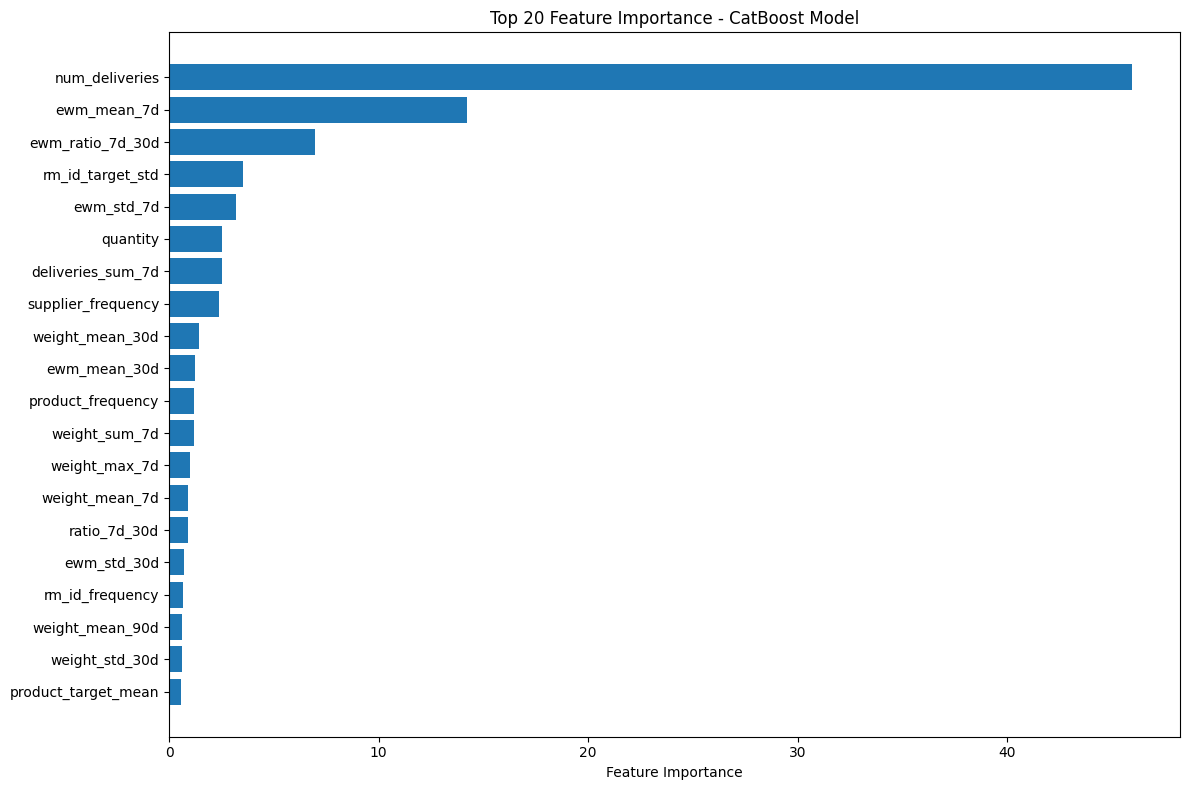


🔍 Residuals Analysis:
   Residuals statistics:
   Mean: -719.18
   Std: 5420.72
   MAE: 3389.73


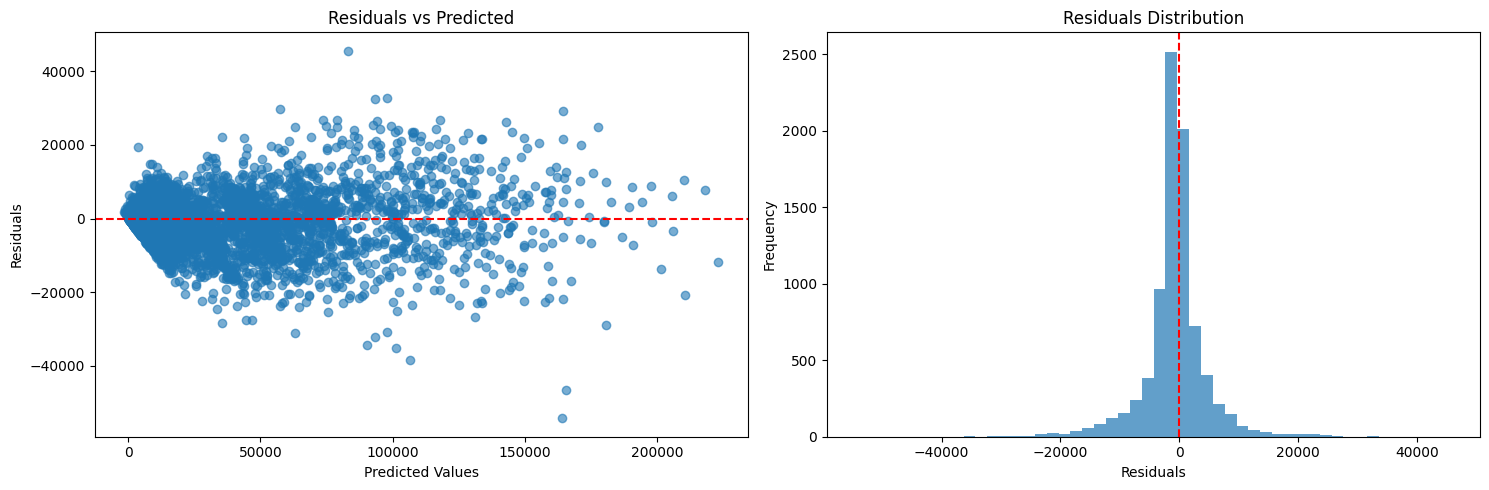

✅ Model analysis completata


In [8]:
# FEATURE IMPORTANCE ANALYSIS
print("🔄 Analisi Feature Importance...")

# Get feature importance
feature_importance = best_catboost.get_feature_importance()
feature_names = X_train.columns

# Create dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"\n📊 Top 15 Most Important Features:")
print(importance_df.head(15).to_string(index=False))

# Plot feature importance (top 20)
plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importance - CatBoost Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Residuals analysis
print(f"\n🔍 Residuals Analysis:")
residuals_test = y_test - y_pred_test

print(f"   Residuals statistics:")
print(f"   Mean: {residuals_test.mean():.2f}")
print(f"   Std: {residuals_test.std():.2f}")
print(f"   MAE: {np.abs(residuals_test).mean():.2f}")

# Plot residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Residuals vs Predicted
ax1.scatter(y_pred_test, residuals_test, alpha=0.6)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')

# Residuals histogram
ax2.hist(residuals_test, bins=50, alpha=0.7)
ax2.axvline(x=0, color='r', linestyle='--')
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Frequency')
ax2.set_title('Residuals Distribution')

plt.tight_layout()
plt.show()

print(f"✅ Model analysis completata")

## ✅ Baseline Model Completato - Summary

In [9]:
print("="*80)
print("✅ BASELINE MODEL COMPLETATO - VERSIONE INTEGRATA")
print("="*80)

print(f"""
🎯 APPROCCIO UNIFICATO IMPLEMENTATO:

1. 📊 REPOSITORY RIFERIMENTO (Advanced ML):
   ✅ Quantile Loss (α=0.2): focus su sottostime
   ✅ CatBoost: robusto, gestisce categorical, feature importance
   ✅ Optuna optimization: {N_TRIALS} trials per hyperparameters
   ✅ Cross-validation: {N_FOLDS}-fold con custom metric

2. 📈 TUO PROGETTO (Domain Knowledge):
   ✅ Time-series split: train/test temporale
   ✅ Feature engineering: 52 advanced features
   ✅ Missing value strategy: domain-specific
   ✅ Performance analysis: residuals e feature importance

📊 PERFORMANCE FINALE:
   Model: CatBoost ottimizzato con Optuna
   Metric: Quantile Loss (α=0.2) + MAE
   Features: 52 features (temporal + domain)
   Best CV Score: {study_catboost.best_value:.4f}
   
   Test Performance:
   - Quantile Loss: {test_ql:.2f}
   - MAE: {test_mae:.2f}

🚀 PROSSIMO STEP: generate_submission.ipynb
   Input: best_catboost_model.pkl
   Output: Submission file per competition
""")

print("="*80)

✅ BASELINE MODEL COMPLETATO - VERSIONE INTEGRATA

🎯 APPROCCIO UNIFICATO IMPLEMENTATO:

1. 📊 REPOSITORY RIFERIMENTO (Advanced ML):
   ✅ Quantile Loss (α=0.2): focus su sottostime
   ✅ CatBoost: robusto, gestisce categorical, feature importance
   ✅ Optuna optimization: 50 trials per hyperparameters
   ✅ Cross-validation: 5-fold con custom metric

2. 📈 TUO PROGETTO (Domain Knowledge):
   ✅ Time-series split: train/test temporale
   ✅ Feature engineering: 52 advanced features
   ✅ Missing value strategy: domain-specific
   ✅ Performance analysis: residuals e feature importance

📊 PERFORMANCE FINALE:
   Model: CatBoost ottimizzato con Optuna
   Metric: Quantile Loss (α=0.2) + MAE
   Features: 52 features (temporal + domain)
   Best CV Score: 2252.3519

   Test Performance:
   - Quantile Loss: 1910.62
   - MAE: 3389.73

🚀 PROSSIMO STEP: generate_submission.ipynb
   Input: best_catboost_model.pkl
   Output: Submission file per competition

